In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [26]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 50
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskCNN(nn.Module):
    def __init__(self, in_channels=16):
        super().__init__()

        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Mask head (binary classification)
        self.mask_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        # Phase head (multi-class classification)
        self.phase_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 5, kernel_size=1)
        )

        # COD regression head
        self.cod_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 1, kernel_size=1)
        )

        # CPS regression head
        self.cps_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 1, kernel_size=1)
        )

    def forward(self, x):
        shared_feats = self.shared(x)

        cloud_mask_logits = self.mask_head(shared_feats)          # [B, 1, H, W]
        cloud_mask = torch.sigmoid(cloud_mask_logits)             # probabilities

        binary_mask = (cloud_mask > 0.5).float()                  # [B, 1, H, W]

        cloud_phase_logits = self.phase_head(shared_feats)        # [B, 5, H, W]
        cod_pred = self.cod_head(shared_feats)                    # [B, 1, H, W]
        cps_pred = self.cps_head(shared_feats)                    # [B, 1, H, W]

        # Zero out other outputs where mask is 0
        cloud_phase_logits = cloud_phase_logits * binary_mask
        cod_pred = cod_pred * binary_mask
        cps_pred = cps_pred * binary_mask

        return cloud_mask_logits, cloud_phase_logits, cod_pred, cps_pred


In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [17]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader,) #loss_weights = loss_weights)
    val_results = eval(model, val_loader,) #loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f}")

100%|██████████| 94/94 [00:31<00:00,  2.98it/s]


Epoch: 1 | Train Loss: 91.9891 | Val Loss: 101.7672


100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Epoch: 2 | Train Loss: 91.1114 | Val Loss: 90.8503


100%|██████████| 94/94 [00:31<00:00,  2.95it/s]


Epoch: 3 | Train Loss: 90.8890 | Val Loss: 97.2137


100%|██████████| 94/94 [01:30<00:00,  1.04it/s]


Epoch: 4 | Train Loss: 90.7830 | Val Loss: 91.3237


100%|██████████| 94/94 [01:44<00:00,  1.11s/it]


Epoch: 5 | Train Loss: 90.3788 | Val Loss: 123.2405


100%|██████████| 94/94 [01:56<00:00,  1.24s/it]


Epoch: 6 | Train Loss: 89.8923 | Val Loss: 86.8759


100%|██████████| 94/94 [01:54<00:00,  1.22s/it]


Epoch: 7 | Train Loss: 90.0637 | Val Loss: 87.9525


100%|██████████| 94/94 [01:39<00:00,  1.06s/it]


Epoch: 8 | Train Loss: 89.2171 | Val Loss: 86.4202


100%|██████████| 94/94 [02:00<00:00,  1.28s/it]


Epoch: 9 | Train Loss: 89.4270 | Val Loss: 88.3131


100%|██████████| 94/94 [02:00<00:00,  1.28s/it]


Epoch: 10 | Train Loss: 89.0294 | Val Loss: 93.1337


100%|██████████| 94/94 [01:52<00:00,  1.20s/it]


Epoch: 11 | Train Loss: 88.3875 | Val Loss: 89.3780


100%|██████████| 94/94 [01:36<00:00,  1.03s/it]


Epoch: 12 | Train Loss: 88.0363 | Val Loss: 90.7292


100%|██████████| 94/94 [01:51<00:00,  1.18s/it]


Epoch: 13 | Train Loss: 88.1519 | Val Loss: 89.9503


100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


Epoch: 14 | Train Loss: 87.7422 | Val Loss: 104.8592


100%|██████████| 94/94 [01:53<00:00,  1.21s/it]


Epoch: 15 | Train Loss: 87.6747 | Val Loss: 94.7272


100%|██████████| 94/94 [01:46<00:00,  1.14s/it]


Epoch: 16 | Train Loss: 87.4495 | Val Loss: 115.4585


100%|██████████| 94/94 [01:53<00:00,  1.20s/it]


Epoch: 17 | Train Loss: 87.1106 | Val Loss: 128.0533


100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


Epoch: 18 | Train Loss: 87.1948 | Val Loss: 81.6694


100%|██████████| 94/94 [01:43<00:00,  1.10s/it]


Epoch: 19 | Train Loss: 86.1893 | Val Loss: 86.2469


100%|██████████| 94/94 [01:50<00:00,  1.18s/it]


Epoch: 20 | Train Loss: 86.3464 | Val Loss: 134.0906


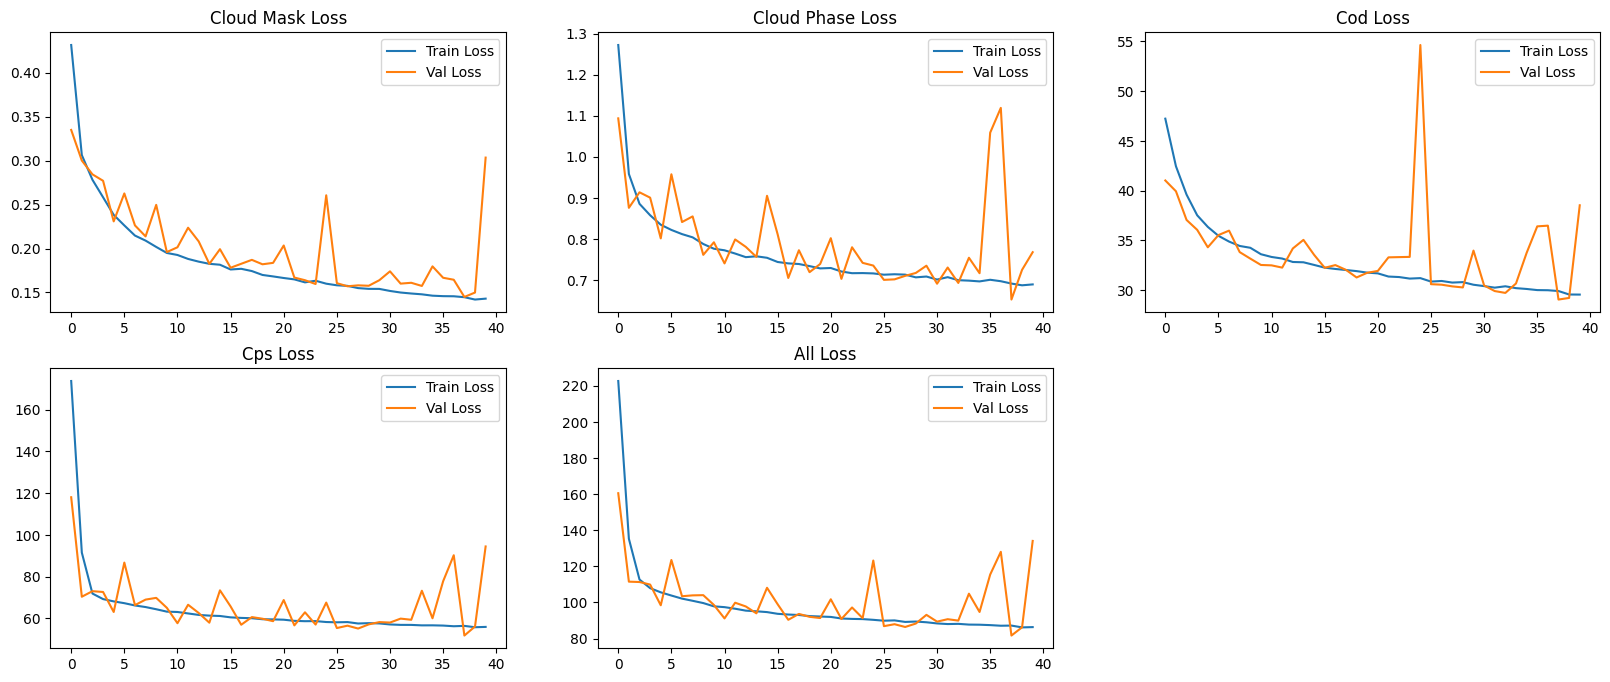

In [18]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

#plt.savefig("./graphs/cloud_mask_unet_loss_and_acc.png")  
#plt.savefig("./graphs/cloud_mask_unet_loss_and_acc.png")  


plt.show()

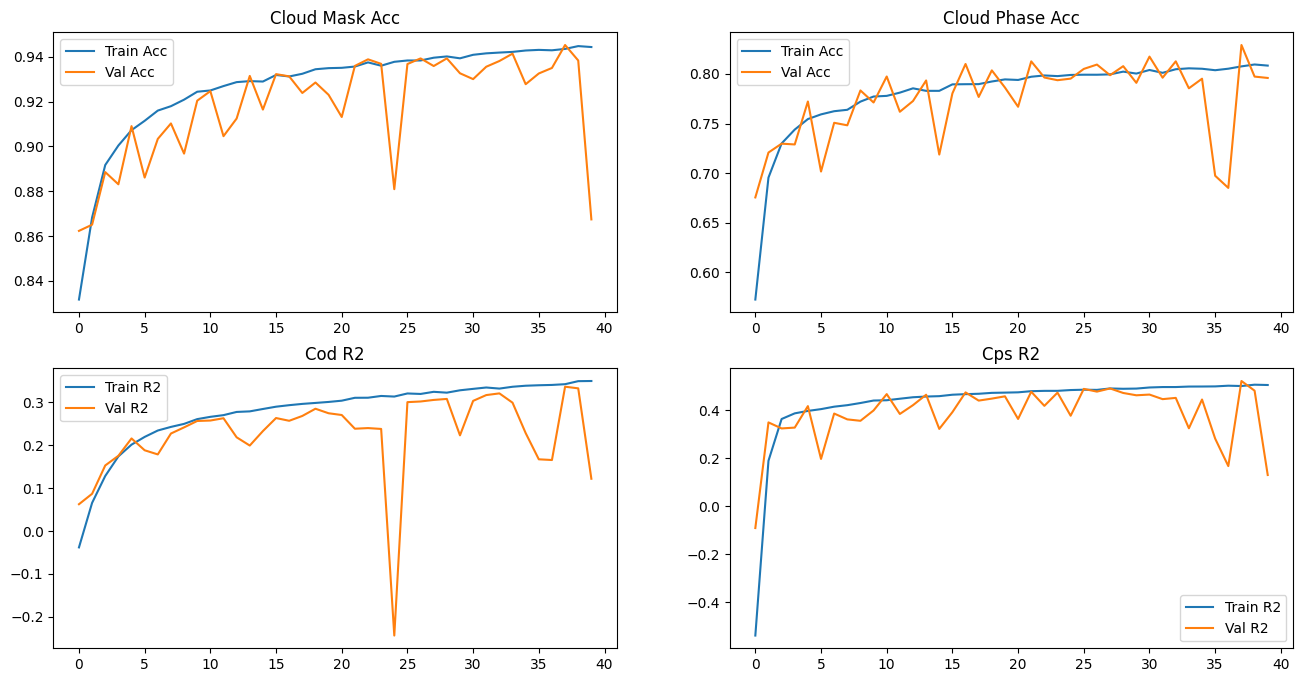

In [19]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.show()

In [20]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))

100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.970     0.413     0.580   5213835
           1      0.863     0.997     0.925  19362165

    accuracy                          0.873  24576000
   macro avg      0.916     0.705     0.752  24576000
weighted avg      0.886     0.873     0.852  24576000

CONFUSION MATRIX:
 [[ 2154607  3059228]
 [   67097 19295068]]


In [21]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.883     0.491     0.631   3995645
           1      0.776     0.931     0.847  10972813
           2      0.812     0.775     0.793   3511301
           3      0.450     0.383     0.414   1141552
           4      0.857     0.842     0.849   4954689

    accuracy                          0.794  24576000
   macro avg      0.756     0.685     0.707  24576000
weighted avg      0.800     0.794     0.784  24576000

CONFUSION MATRIX:
 [[ 1961951  1979945    11577     4655    37517]
 [  221267 10219141   283173    43296   205936]
 [    2337   322467  2722701   359993   103803]
 [    2144    82969   268599   437669   350171]
 [   34334   558052    65925   126827  4169551]]

IOU: [0.4610143  0.73433173 0.65756592 0.2610887  0.73769735]
Unweighted IoU: 0.5703396003949146
Weighted IoU: 0.6576234285058974


In [22]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


r2: 0.1512039303779602
MSE: 39.68212890625


In [23]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


r2: 0.15451383590698242
MSE: 93.7999267578125


In [24]:
# data_iter = iter(test_loader)
# images, labels = next(data_iter)

# images = images.to(device)
# labels = labels.to(device)
# _, cloud_phase_target, _, _ = unpack_labels(labels)
# _, cloud_phase_pred, _, _ = model(images)
# preds = torch.argmax(cloud_phase_pred, dim=1)


In [25]:
# my_image = images[0].cpu().numpy()
# my_image = np.transpose(my_image, (1, 2, 0))
# phase_pred = preds[0].cpu().numpy()
# phase_target = cloud_phase_target[0].cpu().numpy()



# from netCDF4 import Dataset
# import numpy as np


# with Dataset('image1.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', my_image.shape[0])
#     ds.createDimension('y', my_image.shape[1])
#     ds.createDimension('band', my_image.shape[2])

#     var = ds.createVariable('radiance', 'f4', ('x', 'y', 'band'))
#     var[:] = my_image

#     var.units = 'unknown'  # optional metadata

# with Dataset('image2.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_pred.shape[0])
#     ds.createDimension('y', phase_pred.shape[1])

#     var = ds.createVariable('prediction', 'f4', ('x', 'y'))
#     var[:] = phase_pred

#     var.units = 'unknown'  # optional metadata


# with Dataset('image3.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_target.shape[0])
#     ds.createDimension('y', phase_target.shape[1])

#     var = ds.createVariable('target', 'f4', ('x', 'y'))
#     var[:] = phase_target

#     var.units = 'unknown'  # optional metadata

